In [4]:
#install kaggle
#!pip install kaggle


In [5]:
#creates hidden kaggle folder
#!mkdir -p ~/.kaggle

In [6]:
#downloaded kaggle.json

#move kaggle.json file to kaggle folder
#!mv kaggle.json ~/.kaggle/

In [7]:
#setting correct permissions for kaggle
#!chmod 600 ~/.kaggle/kaggle.json

In [8]:
#download data from kaggle
#!kaggle competitions download -c store-sales-time-series-forecasting

In [9]:
#check if downloaded correctly
!ls

README.md                         model_baseline_and_lightgbm.ipynb
Store-Sales.ipynb                 oil_and_holiday_eda.ipynb
eda.ipynb


In [10]:
#unzip downloaded file
#!unzip store-sales-time-series-forecasting.zip -d data


In [11]:
#check if files are there
#!ls data

In [21]:
#import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#nice visualizations
import seaborn as sns

In [29]:
import os
from pathlib import Path

print("cwd:", os.getcwd())
list(Path(".").rglob("train.csv"))


cwd: /Users/vedaporanki/Desktop/Project-Store-Sales


[]

In [39]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("data")

train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")
oil = pd.read_csv(DATA_DIR / "oil.csv")
holidays = pd.read_csv(DATA_DIR / "holidays_events.csv")
stores = pd.read_csv(DATA_DIR / "stores.csv")
transactions = pd.read_csv(DATA_DIR / "transactions.csv")


In [41]:
#understand the dataset

#explains types
#conclusions: date is stored as a string rather than in datetime
oil.info()

#check for missing data
#conclusions: there are 43 NaN values in oil dataset, maybe since weekends don't have changes

oil.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


date           0
dcoilwtico    43
dtype: int64

In [43]:
#convert date to datetime and sort
oil['date'] = pd.to_datetime(oil['date'])
oil = oil.sort_values('date')

# Forward fill missing oil prices
oil['dcoilwtico'] = oil['dcoilwtico'].ffill()

# Backfill the first value if it's still NaN
oil['dcoilwtico'] = oil['dcoilwtico'].bfill()

#check for no missing files
print(oil.isnull().sum())
oil.head()

date          0
dcoilwtico    0
dtype: int64


,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


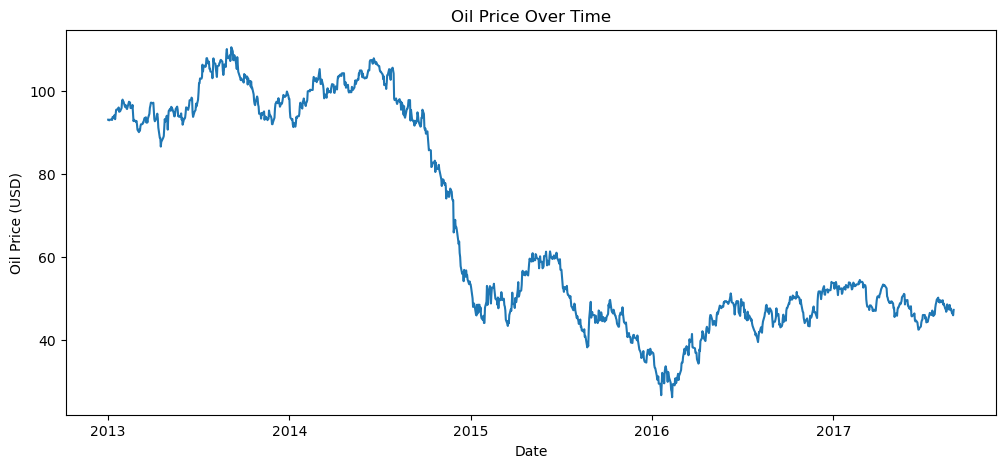

In [45]:
#EDA: see how oil prices have changed over time
#line graph 

plt.figure(figsize=(12,5))
plt.plot(oil['date'], oil['dcoilwtico'])
plt.title('Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD)')
plt.show()

In [47]:
#see how oil prices affect sales
#merge oil prices and sales

train['date'] = pd.to_datetime(train['date'])

merged = train.merge(oil, on='date', how='left')
merged.head()


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,93.14


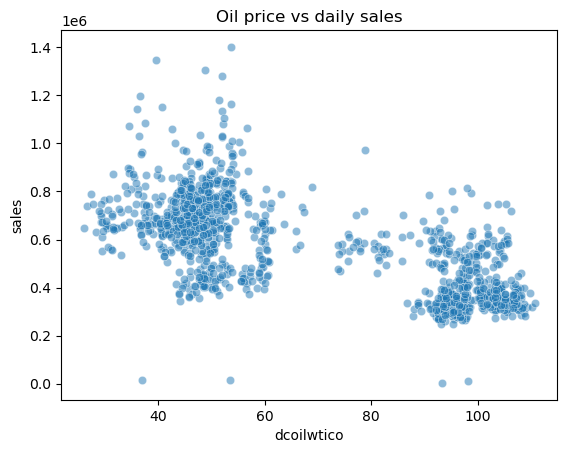

In [49]:
# your existing aggregation
# daily_sales = merged.groupby('date')['sales'].sum().reset_index()
target = 'sales' if 'sales' in merged.columns else 'unit_sales'
daily_sales = merged.groupby('date', as_index=False)[target].sum()

# bring in oil for those dates
oil_for_merge = oil[['date', 'dcoilwtico']]
daily_with_oil = daily_sales.merge(oil_for_merge, on='date', how='left')

#check relationship using seasborn
# scatterplot with oil price vs. total daily sales
sns.scatterplot(data=daily_with_oil, x='dcoilwtico', y=target, alpha=0.5)
plt.title('Oil price vs daily sales')
plt.show()

In [51]:
#create daily datafram

target = 'sales' if 'sales' in merged.columns else 'unit_sales'

# Group by date to get daily total sales and average oil price
daily = merged.groupby('date', as_index=False).agg({
    target: 'sum',
    'dcoilwtico': 'mean'
})

#look at first 5 rows
daily.head()

,date,sales,dcoilwtico
0,2013-01-01,2511.618999,93.14
1,2013-01-02,496092.417944,93.14
2,2013-01-03,361461.231124,92.97
3,2013-01-04,354459.677093,93.12
4,2013-01-05,477350.121229,NaN


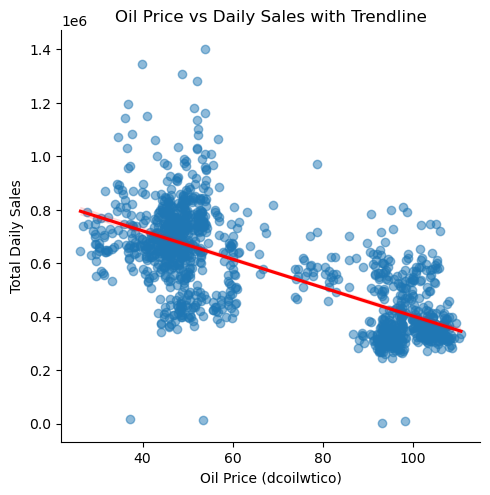

In [53]:
#add trendline for easy understanding

sns.lmplot(data=daily, x='dcoilwtico', y=target, 
           scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Oil Price vs Daily Sales with Trendline')
plt.xlabel('Oil Price (dcoilwtico)')
plt.ylabel('Total Daily Sales')
plt.show()

In [55]:
#holidays vs. sales

#change dates to datetime
holidays['date'] = pd.to_datetime(holidays['date'])

#change dates for train data
train['date'] = pd.to_datetime(train['date'])

In [57]:
#merge holidays with sales
train_holidays = train.merge(holidays, on='date', how='left')
train_holidays.head()

,id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False


In [59]:
#compare holiday to not holidays
# Create binary column: 1 = holiday, 0 = not holiday
train_holidays['is_holiday'] = train_holidays['type'].apply(lambda x: 0 if pd.isnull(x) else 1)


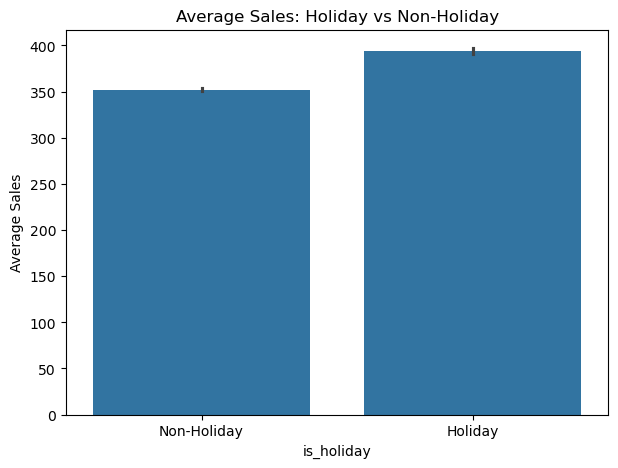

In [61]:
#barplot for sales on holidays and non holidays
plt.figure(figsize=(7,5))
sns.barplot(data=train_holidays, x='is_holiday', y='sales', estimator='mean')
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.xticks([0,1], ['Non-Holiday', 'Holiday'])
plt.ylabel('Average Sales')
plt.show()

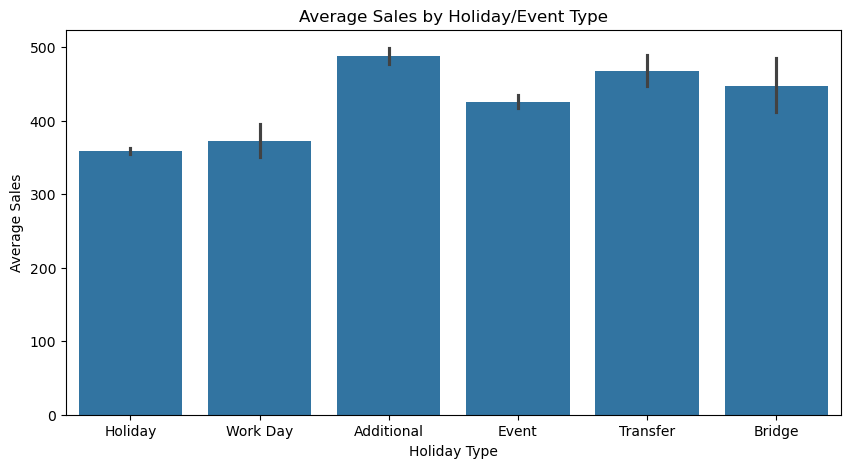

In [62]:
#holiday type
plt.figure(figsize=(10,5))
sns.barplot(data=train_holidays, x='type', y='sales', estimator='mean')
plt.title('Average Sales by Holiday/Event Type')
plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')
plt.show()

In [63]:
#top holidays
top_holidays = (train_holidays.groupby('description')['sales']
                .sum()
                .sort_values(ascending=False)
                .head(10))

print(top_holidays)

description
Carnaval                         5.931967e+06
Navidad-2                        4.336135e+06
Dia del Trabajo                  4.289685e+06
Navidad-4                        3.996473e+06
Dia de la Madre-1                3.983978e+06
Navidad-3                        3.982150e+06
Cantonizacion de Salinas         3.982150e+06
Navidad-1                        3.917164e+06
Provincializacion de Cotopaxi    3.806671e+06
Cantonizacion de El Carmen       3.783027e+06
Name: sales, dtype: float64


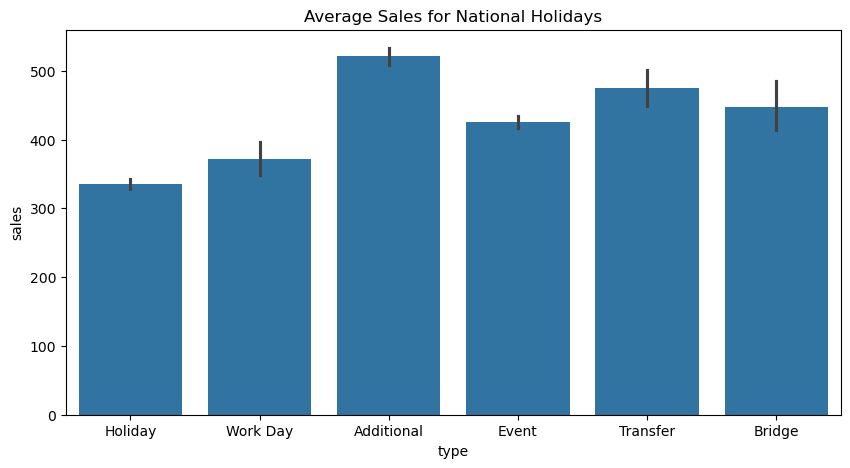

In [64]:
#national holidays
national_holidays = train_holidays[train_holidays['locale'] == 'National']

plt.figure(figsize=(10,5))
sns.barplot(data=national_holidays, x='type', y='sales', estimator='mean')
plt.title('Average Sales for National Holidays')
plt.show()


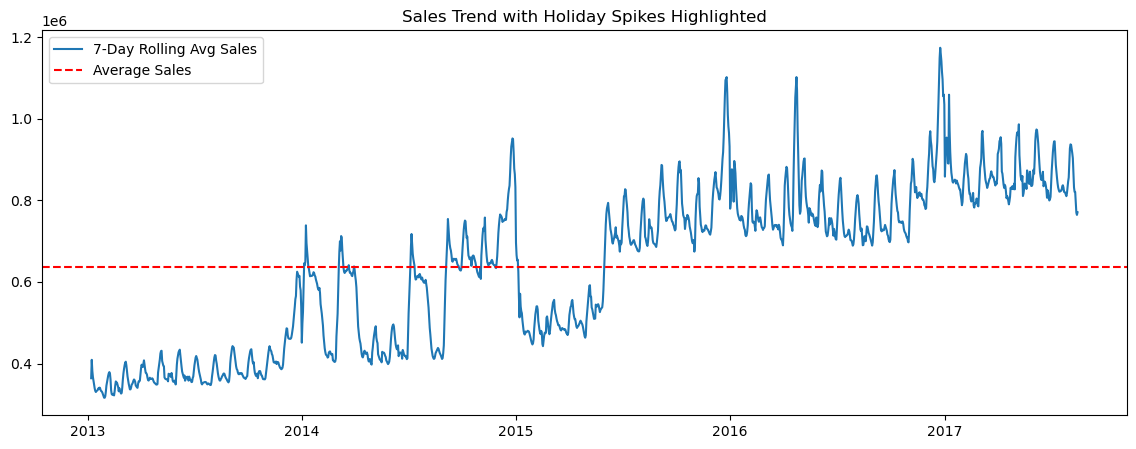

In [65]:
#time trends around holidays
daily_sales = train.groupby('date')['sales'].sum().reset_index()
daily_sales['rolling_7d'] = daily_sales['sales'].rolling(7).mean()

plt.figure(figsize=(14,5))
plt.plot(daily_sales['date'], daily_sales['rolling_7d'], label='7-Day Rolling Avg Sales')
plt.axhline(daily_sales['sales'].mean(), color='red', linestyle='--', label='Average Sales')
plt.title('Sales Trend with Holiday Spikes Highlighted')
plt.legend()
plt.show()

In [72]:
#final merge for modeling

# 1. Make sure all dates are datetime
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

# 2. Merge oil prices into train
merged = train.merge(oil, on='date', how='left')

# 3. Merge holidays into that
merged = merged.merge(holidays[['date', 'type']], on='date', how='left')

# 4. Create useful columns
merged['is_holiday'] = merged['type'].apply(lambda x: 0 if pd.isnull(x) else 1)
merged['month'] = merged['date'].dt.month
merged['dayofweek'] = merged['date'].dt.dayofweek
merged['year'] = merged['date'].dt.year

# 5. Fill missing oil values (just in case)
merged['dcoilwtico'] = merged['dcoilwtico'].ffill().bfill()

# 6. Drop unneeded columns
merged = merged.drop(columns=['type'])

# 7. Save to CSV for modeling
merged.to_csv('cleaned_sales_data.csv', index=False)

print("✅ Cleaned dataset saved as 'cleaned_sales_data.csv'")
merged.head()


✅ Cleaned dataset saved as 'cleaned_sales_data.csv'


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,is_holiday,month,dayofweek,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,1,1,1,2013
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,1,1,1,2013
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,1,1,1,2013
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,1,1,1,2013
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,1,1,1,2013
